# Overfitting Crab Age

###### *In which we practice one thing so much that we get worse at everything else.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/0-eda)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/0-eda/overfit.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


### Define Constants


In [55]:
%%time
CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../1-models/models.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/overfit_model.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]



CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries

PyTorch supports windows-native CUDA, but TensorFlow on CPU was faster for this task.


In [56]:
%%time
from notebooks.time_for_crab.mlutils import display_df, plot_training_loss, score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 0 ns
Wall time: 505 µs


### Load Data from Cache

In the [previous section](../0-eda/eda.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [57]:
%%time
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

## Overfitting Crab Age

![Large mud crab measure](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg/1920px-CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg)


### Overfitting Goals and Methods 

The goal here is to show how complex of a model it will take to overfit the data.

We will use the following methods to overfit the data:

1. **Linear Regression**: Gradually increase the complexity of a linear regression model.
2. **Deep Learning**: Use deep learning to overfit the model.

I am following the TensorFlow tutorial on [Linear Regression](https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable) to build the linear regression model.

> There are two steps in your single-variable linear regression model:  
>    1. Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
>    2. Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (tf.keras.layers.Dense).

Instead of 'Horsepower', we'll use 'Shell Weight' as our regression variable.


## Metrics Used

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

#### Max Error

- The max error is the very worst score.
- Lower is better.
- Domain-specific.
- 10 years is a lot for a crab.


## Build the Shell Weight Model

This is a simple linear regression model that predicts the age of a crab based on its shell weight. It remains untrained.


#### Layer: Input Layer

This defines the shape of our input to the model.


In [58]:
%%time
shell_weight_input = keras.layers.Input(shape=(1,))


CPU times: total: 0 ns
Wall time: 998 µs


#### Layer: Shell Weight Normalizer Layer

This is a quick and easy way to normalize our input data.

***Note**: In later steps, we will use a custom normalizer to show how it's done.*


In [59]:
%%time
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)


CPU times: total: 0 ns
Wall time: 5 ms


#### Layer: Dense Layer

This is the layer that will perform the linear regression.


In [60]:
%%time
shell_weight_dense = keras.layers.Dense(units=1)


CPU times: total: 0 ns
Wall time: 0 ns


### Architecture: Shell Weight Model

Now we'll put all the layers together to create the model. It is still going to be untrained.


In [61]:
%%time
shell_weight_model = keras.Sequential([
    shell_weight_input,
    shell_weight_normalizer,
    shell_weight_dense
])

shell_weight_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

CPU times: total: 0 ns
Wall time: 9.52 ms


### Predictions: Pre-Training (For Science)

We don't expect good results here. This is just to get a baseline.

***Note**: We are not going to split the data into training and testing sets. We are trying to overfit the data on purpose.*


In [62]:
%%time
# define the prediction target as a numpy array
prediction_target = np.array(crabs[PREDICTION_TARGET])
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(prediction_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
[9 6 6 ... 5 6 8]
[-0.04286303  1.6817248   1.281345   ...  1.9882605   1.210556
  1.729134  ]
CPU times: total: 31.2 ms
Wall time: 137 ms


#### Scores: Naive Model


In [63]:
%%time
# Utility functions imported from mlutils.py
naive_scores_df = score_model(shell_weight_preds, prediction_target, index='naive')
naive_scores_df.head()


CPU times: total: 0 ns
Wall time: 2 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.27113


#### Observations: Naive Model

As expected, the untrained scores are terrible.


### Prepare the Shell Weight Model

Now it's finally time to get learning!

#### Compile

We will use the mean squared error as the loss function and the Adam optimizer.


In [64]:
%%time
shell_weight_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


CPU times: total: 0 ns
Wall time: 2.52 ms


#### Checkpoint the Shell Weight Model

We want to save the model for later reference.


In [65]:
%%time
shell_weight_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'shell_weight'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 0 ns


### Train the Shell Weight Model

Let's train for 100 epochs.


In [66]:
%%time
history = shell_weight_model.fit(
    x=crabs['Shell Weight'],
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[shell_weight_checkpoint]
)


CPU times: total: 625 ms
Wall time: 7.99 s


#### Plot Training History


In [67]:
%%time
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()


CPU times: total: 0 ns
Wall time: 1.01 ms


,loss,val_loss,epoch
95,5.170904,5.032252,95
96,5.143735,5.051764,96
97,5.165386,4.985001,97
98,5.169468,5.047848,98
99,5.165964,5.035779,99


#### Plot Loss History


CPU times: total: 0 ns
Wall time: 8.51 ms


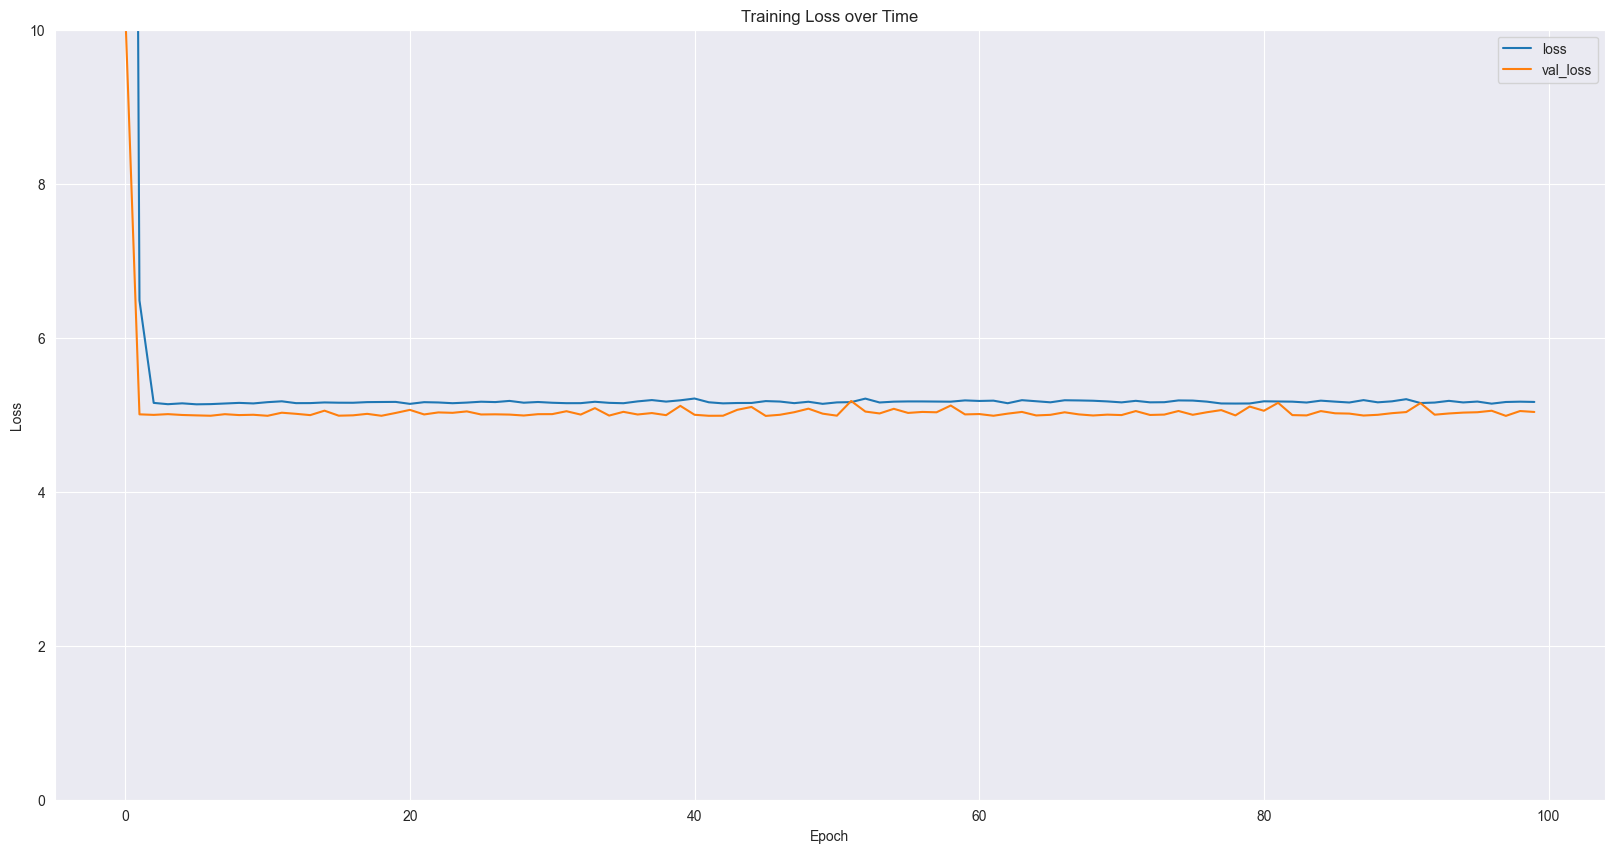

In [68]:
%%time
# Utility functions imported from mlutils.py
plot_training_loss(history)


#### View the Line of Best Fit

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
CPU times: total: 15.6 ms
Wall time: 73.7 ms


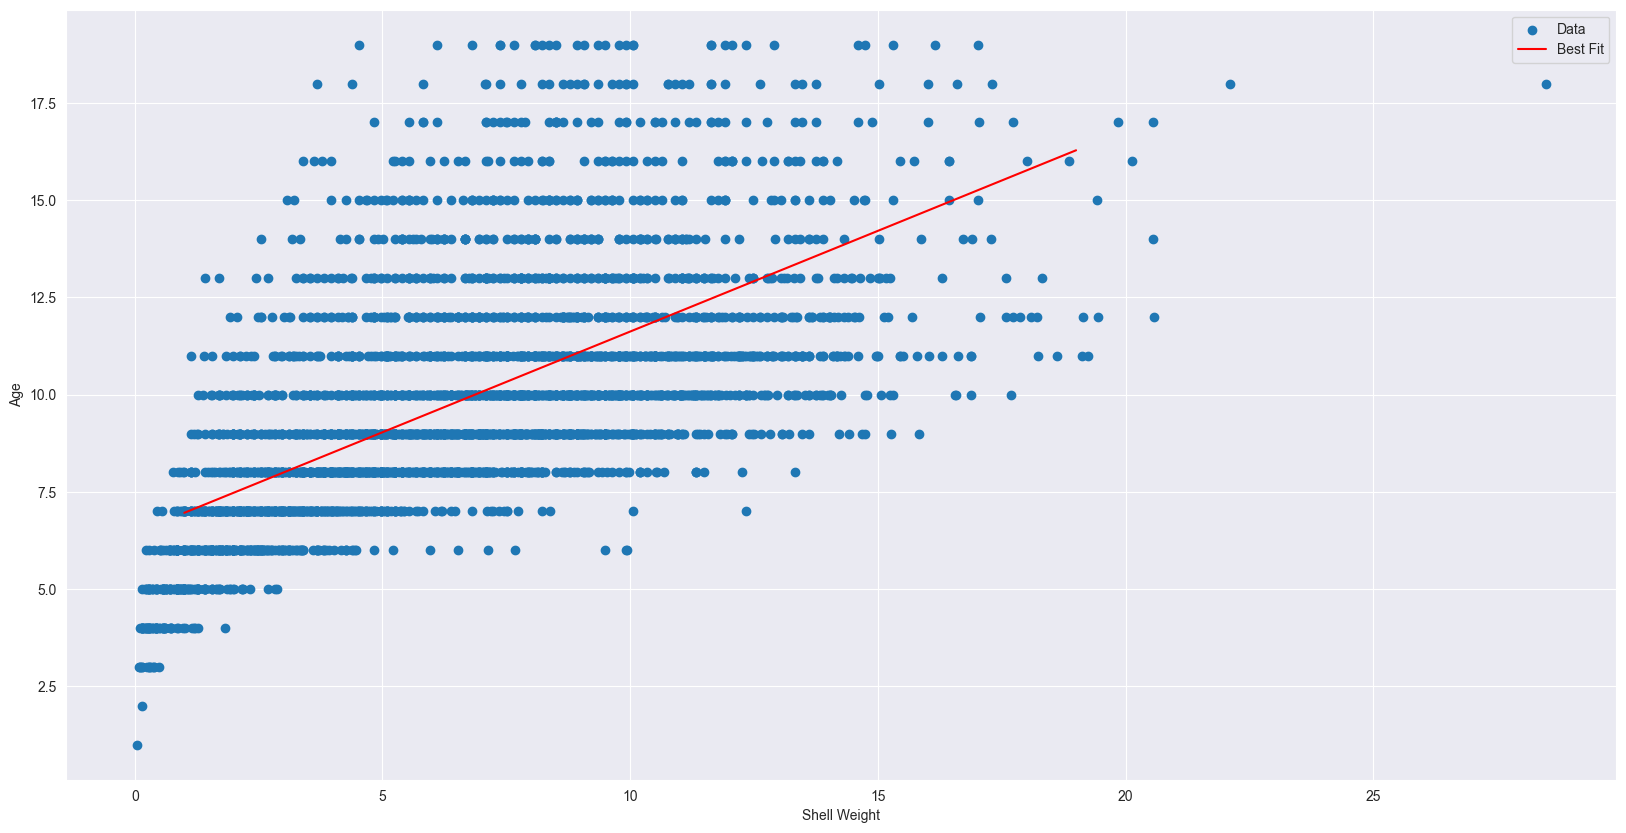

In [69]:
%%time
x = np.linspace(crabs[PREDICTION_TARGET].min(), crabs[PREDICTION_TARGET].max(), 100)
y = shell_weight_model.predict(x).flatten()

plt.figure(figsize=(20, 10))
plt.scatter(crabs['Shell Weight'], crabs['Age'], label='Data')
plt.plot(x, y, color='red', label='Best Fit')
plt.xlabel('Shell Weight')
plt.ylabel('Age')
plt.legend()


### Predictions: Shell Weight Model

Now that we've trained the model, let's see how it performs.

We have only trained the model on one feature, 'Shell Weight'. It is unlikely that just one feature (*except maybe the target itself*) will be able to overfit the data.


In [70]:
%%time
shell_weight_preds = shell_weight_model.predict(shell_weight).flatten()

print(prediction_target)
print(shell_weight_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
[9 6 6 ... 5 6 8]
[9.939282  7.2531652 7.8767734 ... 6.775723  7.98703   7.179323 ]
CPU times: total: 31.2 ms
Wall time: 110 ms


#### Scores: Shell Weight Model

Reminder of our metrics:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.


In [71]:
%%time
# Utility functions imported from mlutils.py
shell_weight_scores_df = score_model(shell_weight_preds, shell_weight, index='shell_weight')
leaderboard_df = score_combine(naive_scores_df, shell_weight_scores_df)
leaderboard_df.head()


CPU times: total: 0 ns
Wall time: 3.01 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.271130
shell_weight,13.905619,3.343205,0.133495,-2.646485,7.286766


### Comparison: Naive vs Shell Weight

CPU times: total: 0 ns
Wall time: 20 ms


<Axes: title={'center': 'Naive vs Trained Model Scores'}>

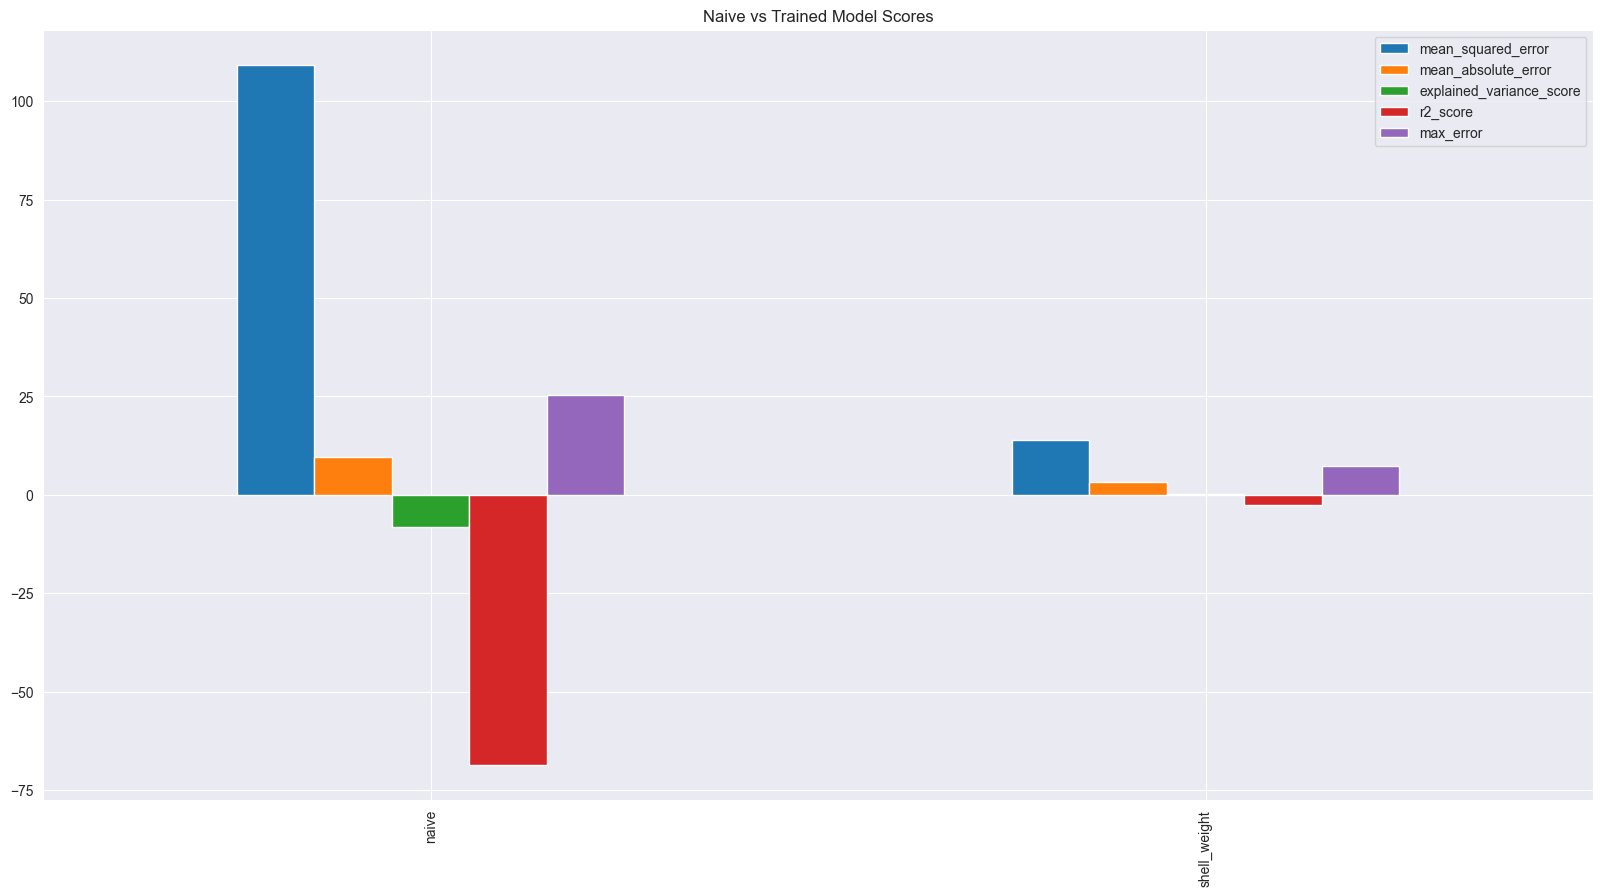

In [72]:
%%time
leaderboard_df.loc[['naive', 'shell_weight']].plot(kind='bar', title='Naive vs Trained Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Naive vs Shell Weight

Break down the bar charts into one for each metric.


CPU times: total: 0 ns
Wall time: 35.3 ms


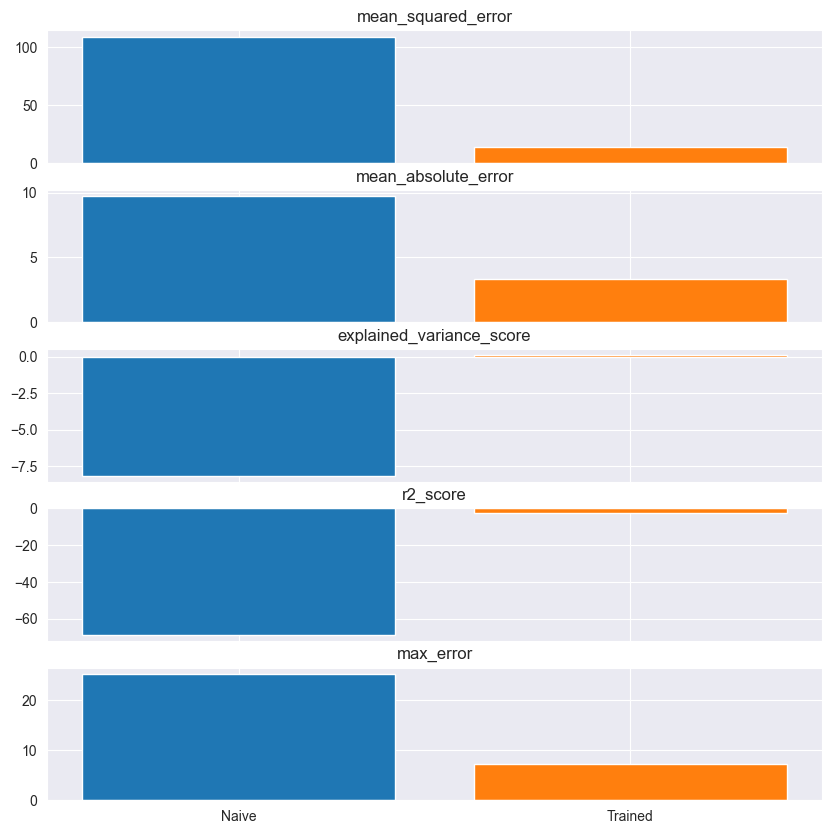

In [73]:
%%time
# Utility functions imported from mlutils.py
score_comparator(naive_scores_df, shell_weight_scores_df, train_label='Naive', test_label='Trained')


### Observations: Shell Weight Model

The scores are much better after training! But not even close to overfitting the data.

Shell Weight alone must not be a good predictor of crab age.


## Build the Feature-Rich Model

Moving onto [linear regression with multiple variables](https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_multiple_inputs) in the TensorFlow tutorial.

In order to overfit, we're going to need to give the model more features from the dataset.

Shell Weight alone is not going to cut it. We need to increase the complexity to a point where the model is just memorizing the training data.

We'll increase the input dimensions to the number of crab features. We exclude the target column from this count.

### Architecture: Feature-Rich Model

- **Input Layer**
    - Shape of the input data.
- **Normalizer Layer**
    - This time adapt to the entire dataset. 
- **Dense Layer**
    - Linear regression layer.


In [74]:
%%time
# layer: input - all features except the target
feature_rich_input = keras.layers.Input(shape=(len(crabs.columns) - 1,))

# layer: normalizer - all features except the target
feature_rich_normalizer = keras.layers.Normalization(axis=-1)
feature_rich_normalizer.adapt(np.array(crabs.drop(columns=[PREDICTION_TARGET])))

# layer: dense (linear regression) - one output
feature_rich_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> dense
feature_rich_model = keras.Sequential([
    feature_rich_input,
    feature_rich_normalizer,
    feature_rich_output
])

feature_rich_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (132.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 22.1 ms


### Prepare the Feature-Rich Model

#### Compile

We will use the mean squared error as the loss function and the Adam optimizer.


In [75]:
%%time
feature_rich_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Checkpoint the Feature-Rich Model

We want to save the model for later reference.


In [76]:
%%time
feature_rich_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'feature_rich'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 0 ns


### Train the Feature-Rich Model

Let's train for 100 epochs.

***Reminder**: We are not splitting the data for this experiment.*


In [77]:
%%time
feature_rich_history = feature_rich_model.fit(
    x=crabs.drop(columns=[PREDICTION_TARGET]),
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[feature_rich_checkpoint]
)


CPU times: total: 1.7 s
Wall time: 7.97 s


#### Plot Loss History

CPU times: total: 0 ns
Wall time: 8.52 ms


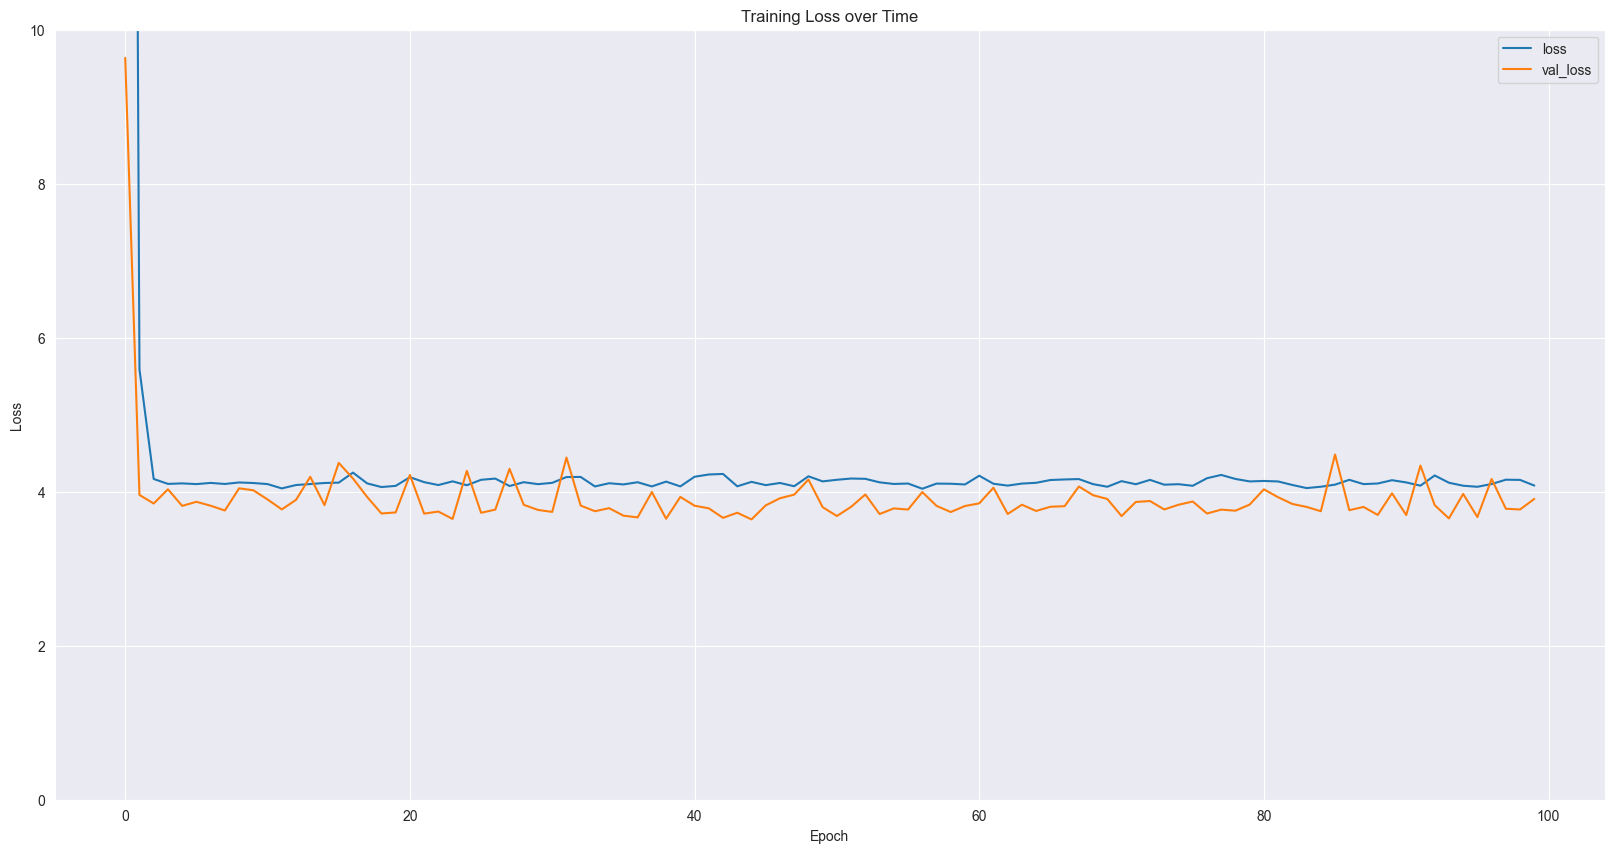

In [78]:
%%time
# Utility functions imported from mlutils.py
plot_training_loss(feature_rich_history)


### Predictions: Feature-Rich Model

We are hoping it did *too* well.


In [79]:
%%time
prediction_target = np.array(crabs[PREDICTION_TARGET])
feature_rich_preds = feature_rich_model.predict(crabs.drop(columns=[PREDICTION_TARGET])).flatten()

print(prediction_target)
print(feature_rich_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
[9 6 6 ... 5 6 8]
[10.445873   7.138054   7.834819  ...  5.769063   7.6951942  6.7870207]
CPU times: total: 31.2 ms
Wall time: 130 ms


#### Scores: Feature-Rich Model


In [80]:
%%time
# Utility functions imported from mlutils.py
feature_rich_scores_df = score_model(feature_rich_preds, prediction_target, index='feature_rich')
leaderboard_df = score_combine(leaderboard_df, feature_rich_scores_df)
leaderboard_df.head()


CPU times: total: 0 ns
Wall time: 2 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.271130
shell_weight,13.905619,3.343205,0.133495,-2.646485,7.286766
feature_rich,4.027237,1.512179,0.191359,0.186990,9.107718


### Comparison: Shell Weight vs Feature-Rich

We'll see if this feature-rich model is any better than the Shell Weight model.


CPU times: total: 0 ns
Wall time: 20 ms


<Axes: title={'center': 'Shell Weight vs Feature-Rich Model Scores'}>

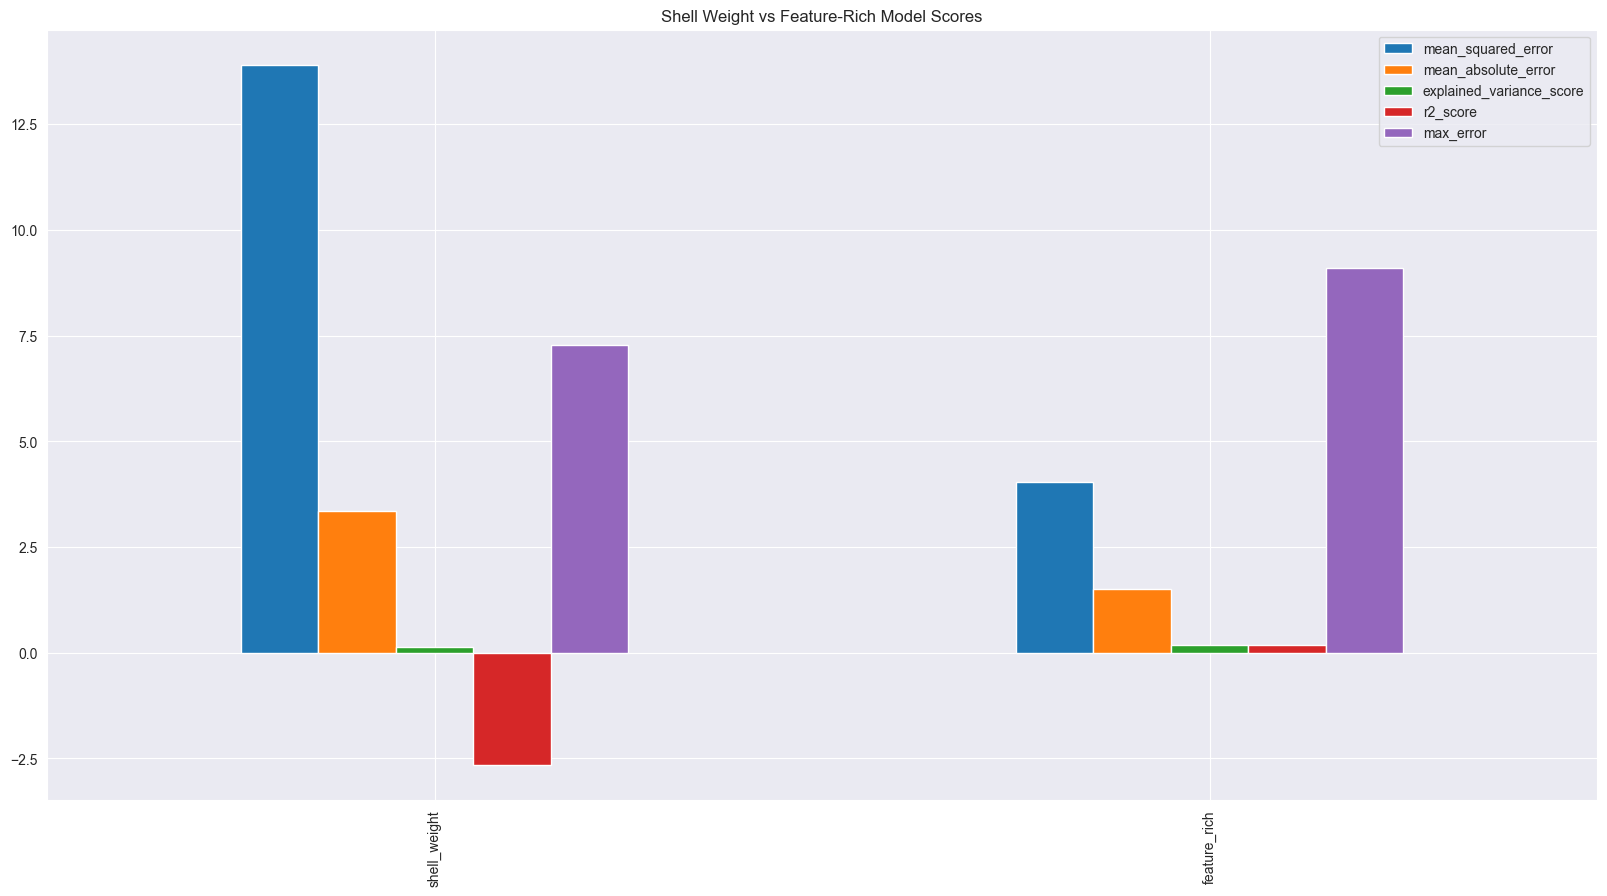

In [81]:
%%time
leaderboard_df.loc[['shell_weight', 'feature_rich']].plot(kind='bar', title='Shell Weight vs Feature-Rich Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Shell Weight vs Feature-Rich

Break down the bar charts into one for each metric.


CPU times: total: 0 ns
Wall time: 36.9 ms


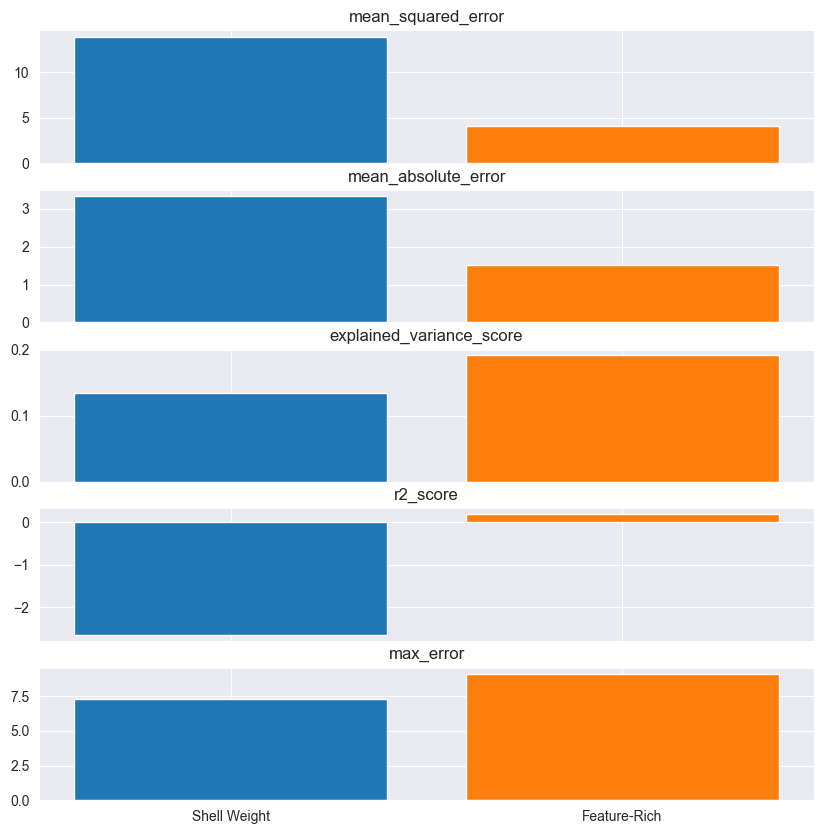

In [82]:
%%time
# Utility functions imported from mlutils.py
score_comparator(shell_weight_scores_df, feature_rich_scores_df, train_label='Shell Weight', test_label='Feature-Rich')


### Observations: Feature-Rich Model

The scores are better than the Shell Weight model, but not by much. We must go deeper!


## Build the Deep Learning Model

Since using all features didn't help, we'll start adding layers.

Getting to the [deep learning part](https://www.tensorflow.org/tutorials/keras/regression#regression_with_a_deep_neural_network_dnn) of the TensorFlow tutorial.

### Architecture: Deep Learning Model

- **Input Layer**
    - Shape of the input data.
- **Normalizer Layer**
- **Hidden Layers**
    - Two dense layers with 64 units and ReLU activation.
- **Output Layer**
    - Linear regression layer with one output.


In [83]:
%%time
# layer: input - reusing the feature-rich input
# layer: normalizer - reusing the feature-rich normalizer

# layer: hidden x2
num_hidden_layers = 2
layer_deep_hidden_relu_list = \
    [keras.layers.Dense(units=64, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_deep_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden x2 -> dense
deep_model = keras.Sequential([
    feature_rich_input,
    feature_rich_normalizer,
    *layer_deep_hidden_relu_list,
    layer_deep_output
])

deep_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,950 (19.34 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 16.5 ms


### Prepare the Deep Learning Model

#### Compile

We will use the mean absolute error as the loss function and the Adam optimizer.

***Note**: We are now using the Adam optimizer with a learning rate of 0.001.*


In [84]:
%%time
deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


CPU times: total: 0 ns
Wall time: 1e+03 µs


#### Checkpoint the Deep Learning Model

We want to save the model for later reference.


In [85]:
%%time
deep_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'deep'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 0 ns


### Train the Deep Learning Model

Let's train for 100 epochs.

In [86]:
%%time
deep_history = deep_model.fit(
    x=crabs.drop(columns=[PREDICTION_TARGET]),
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[deep_checkpoint]
)


CPU times: total: 2.25 s
Wall time: 9.14 s


#### Plot Loss History

CPU times: total: 15.6 ms
Wall time: 7.51 ms


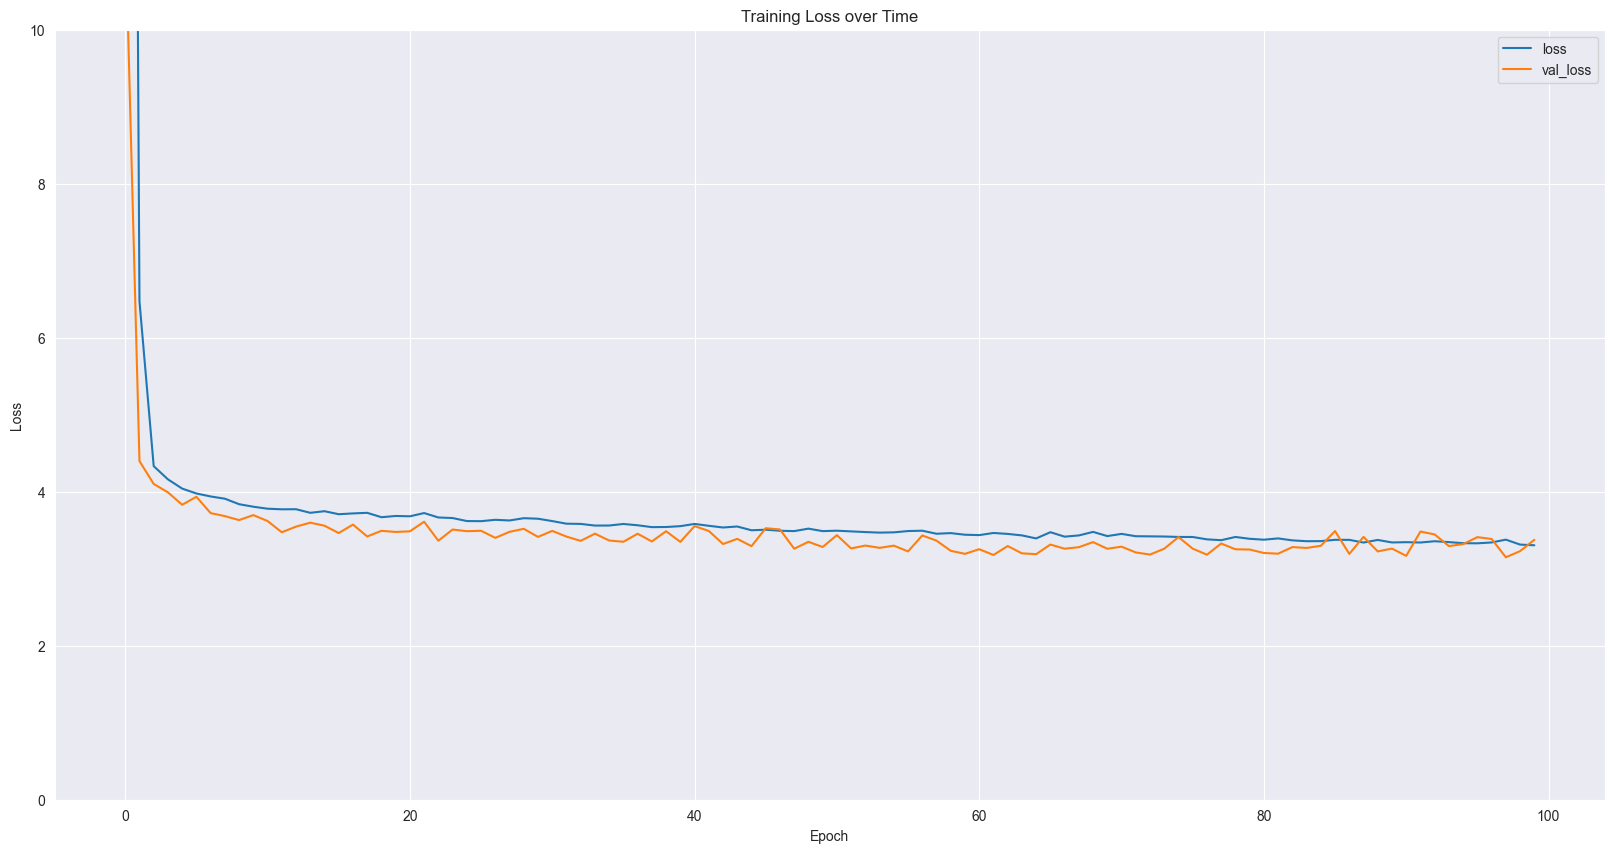

In [87]:
%%time
# Utility functions imported from mlutils.py
plot_training_loss(deep_history)


### Predictions: Deep Learning Model

We are hoping it did *too* well, but based on that loss history, we're not expecting much.


In [88]:
%%time
deep_preds = deep_model.predict(crabs.drop(columns=[PREDICTION_TARGET])).flatten()

print(prediction_target)
print(deep_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
[9 6 6 ... 5 6 8]
[9.511273  7.7354794 7.4985538 ... 4.719049  7.2842455 6.4986563]
CPU times: total: 31.2 ms
Wall time: 154 ms


#### Scores: Deep Learning Model

Reminder of our metrics:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.


In [89]:
%%time
# Utility functions imported from mlutils.py
deep_scores_df = score_model(deep_preds, prediction_target, index='deep')
leaderboard_df = score_combine(leaderboard_df, deep_scores_df)
leaderboard_df.head()


CPU times: total: 0 ns
Wall time: 3.01 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.271130
shell_weight,13.905619,3.343205,0.133495,-2.646485,7.286766
feature_rich,4.027237,1.512179,0.191359,0.186990,9.107718
deep,3.345500,1.377872,0.479164,0.473581,8.798338


### Comparison: Feature-Rich vs Deep Learning

We'll see if this deep learning model is any better than the feature-rich model.

CPU times: total: 15.6 ms
Wall time: 19 ms


<Axes: title={'center': 'Feature-Rich vs Deep Learning Model Scores'}>

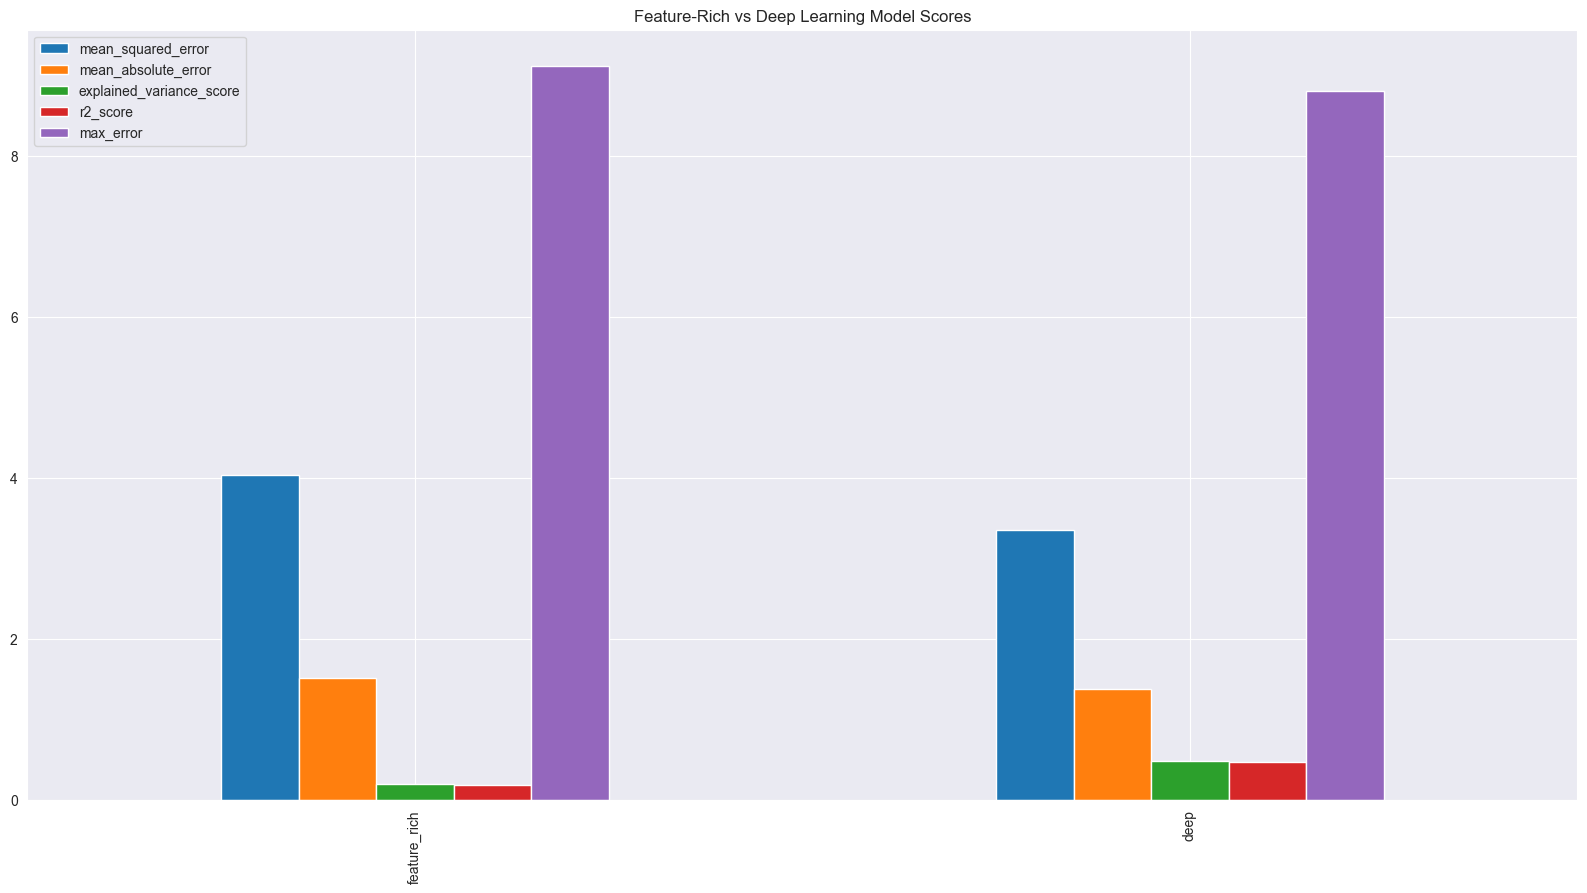

In [90]:
%%time
leaderboard_df.loc[['feature_rich', 'deep']].plot(kind='bar', title='Feature-Rich vs Deep Learning Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Feature-Rich vs Deep Learning

Break down the bar charts into one for each metric.


CPU times: total: 93.8 ms
Wall time: 191 ms


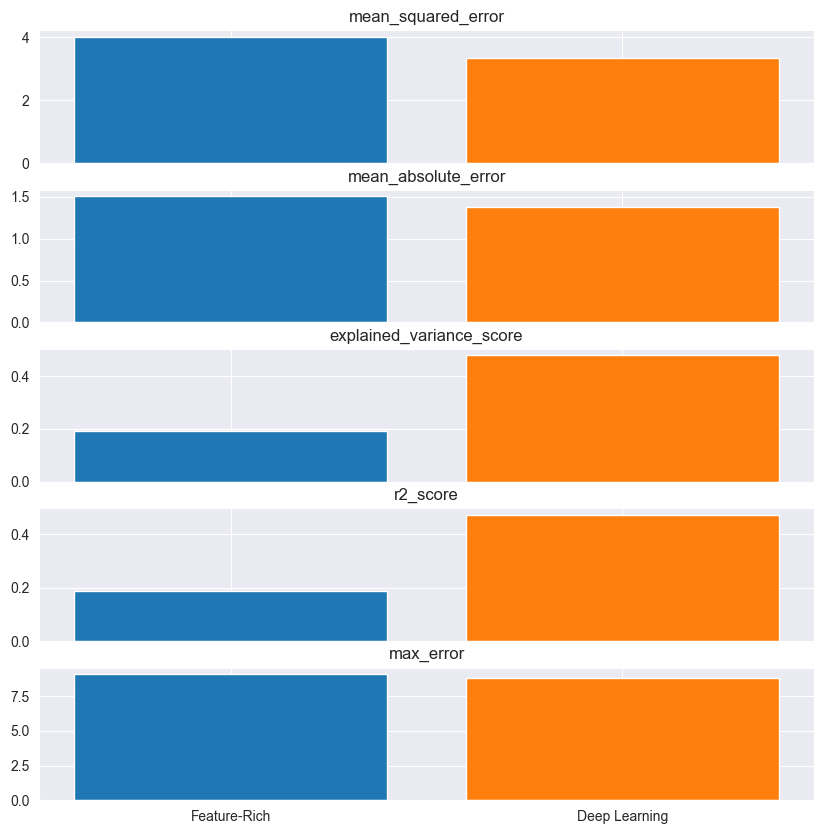

In [91]:
%%time
# Utility functions imported from mlutils.py
score_comparator(feature_rich_scores_df, deep_scores_df, train_label='Feature-Rich', test_label='Deep Learning')


### Observations: Deep Learning Model

The scores are better than the Feature-Rich model! It even flipped the script on *Explained Variance* and *R2* scores.

We're trending in the right direction, but we're not overfitting yet.


## Build the Deep Learning Model with MAE Loss

Maybe we can try Mean Absolute Error as the loss function. The mean squared error is more sensitive to outliers.

### Architecture: Deep Learning Model with MAE Loss

Same as before, but with a different loss function.


In [92]:
%%time
# layer: input - reusing the feature-rich input
# layer: normalizer - reusing the feature-rich normalizer

# layer: hidden x2
num_hidden_layers = 2
layer_deep_abs_relu_list = \
    [keras.layers.Dense(units=64, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_deep_abs_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden x2 -> dense
deep_abs_model = keras.Sequential([
    feature_rich_input,
    feature_rich_normalizer,
    *layer_deep_abs_relu_list,
    layer_deep_abs_output
])

deep_abs_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,950 (19.34 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 17 ms


### Prepare the Deep Learning Model with MAE Loss

#### Compile

We will use the mean absolute error as the loss function this time.

In [93]:
%%time
deep_abs_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)


CPU times: total: 0 ns
Wall time: 1.01 ms


#### Checkpoint the Deep Learning Model with MAE Loss

We want to save the model for later reference.

In [94]:
%%time
deep_abs_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'deep_abs'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 0 ns


### Train the Deep Learning Model with MAE Loss

In [95]:
%%time
deep_abs_history = deep_abs_model.fit(
    x=crabs.drop(columns=[PREDICTION_TARGET]),
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2,
    callbacks=[deep_abs_checkpoint]
)


CPU times: total: 2.98 s
Wall time: 9.71 s


#### Plot Loss History

CPU times: total: 0 ns
Wall time: 8.01 ms


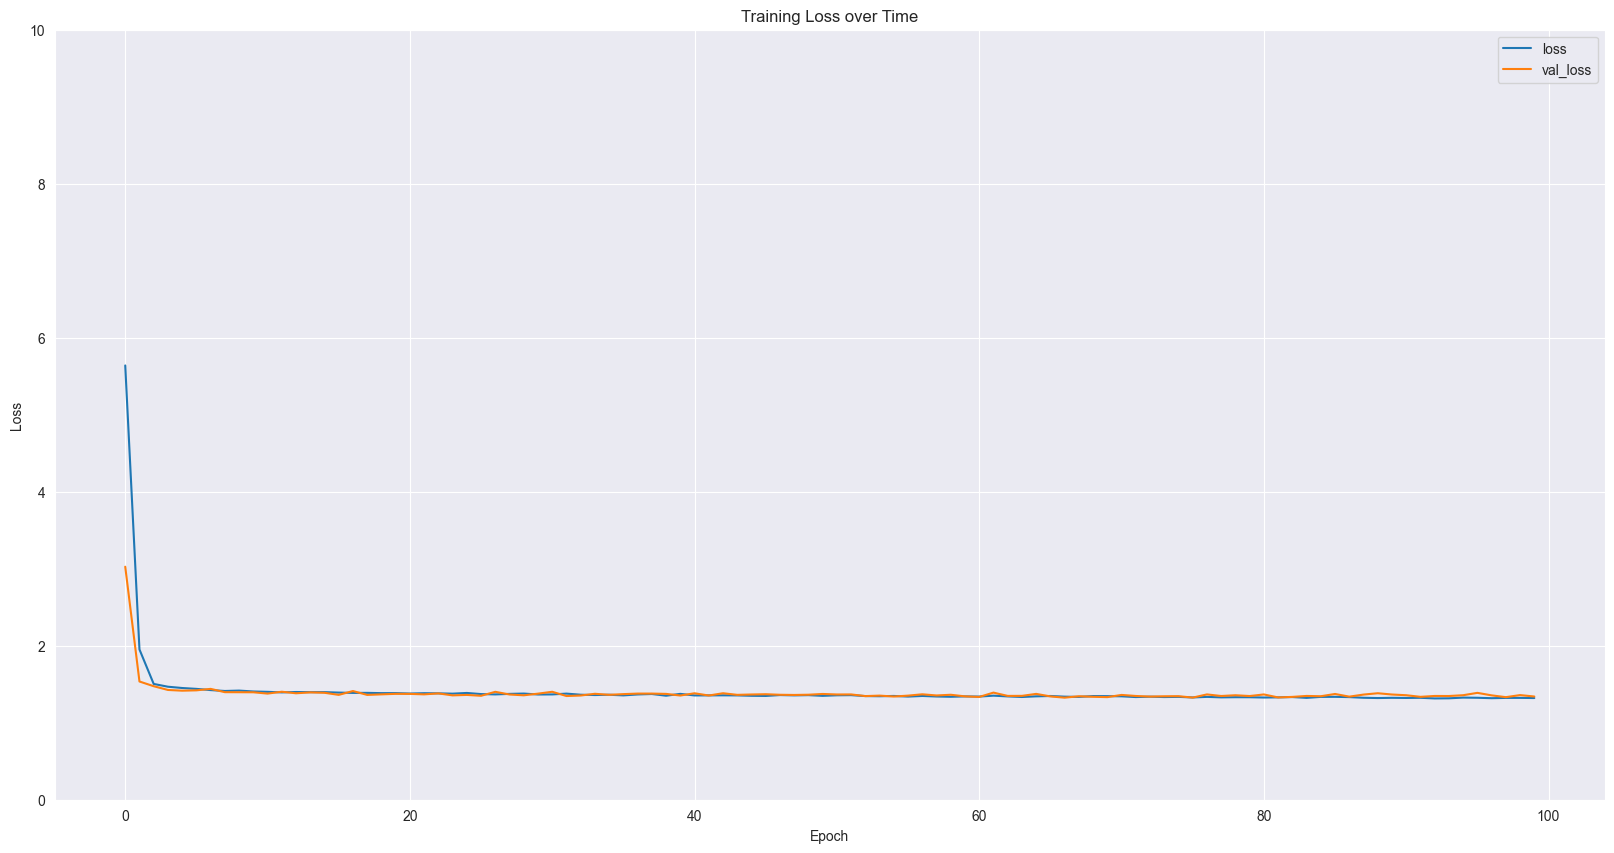

In [96]:
%%time
# Utility functions imported from mlutils.py
plot_training_loss(deep_abs_history)


### Predictions: Deep Learning Model with MAE Loss

It looks better. It seems to have started out pretty good. Or maybe it's just a different scale we need to get used to.


In [97]:
%%time
deep_abs_preds = deep_abs_model.predict(crabs.drop(columns=[PREDICTION_TARGET])).flatten()

print(prediction_target)
print(deep_abs_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
[9 6 6 ... 5 6 8]
[8.748974  8.009542  7.297228  ... 4.8837047 7.110478  6.386002 ]
CPU times: total: 46.9 ms
Wall time: 151 ms


#### Scores: Deep Learning Model with MAE Loss


In [98]:
%%time
# Utility functions imported from mlutils.py
deep_abs_scores_df = score_model(deep_abs_preds, prediction_target, index='deep_abs')
leaderboard_df = score_combine(leaderboard_df, deep_abs_scores_df)
leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.271130
shell_weight,13.905619,3.343205,0.133495,-2.646485,7.286766
feature_rich,4.027237,1.512179,0.191359,0.186990,9.107718
deep,3.345500,1.377872,0.479164,0.473581,8.798338
deep_abs,3.421463,1.314849,0.346032,0.342647,9.276073


### Comparison: Deep Learning vs Deep Learning with MAE Loss

This is a good experiment to see if the loss function makes a difference. We *did* have some outliers in the data.

CPU times: total: 0 ns
Wall time: 21.7 ms


<Axes: title={'center': 'Deep Learning vs Deep Learning with MAE Loss Model Scores'}>

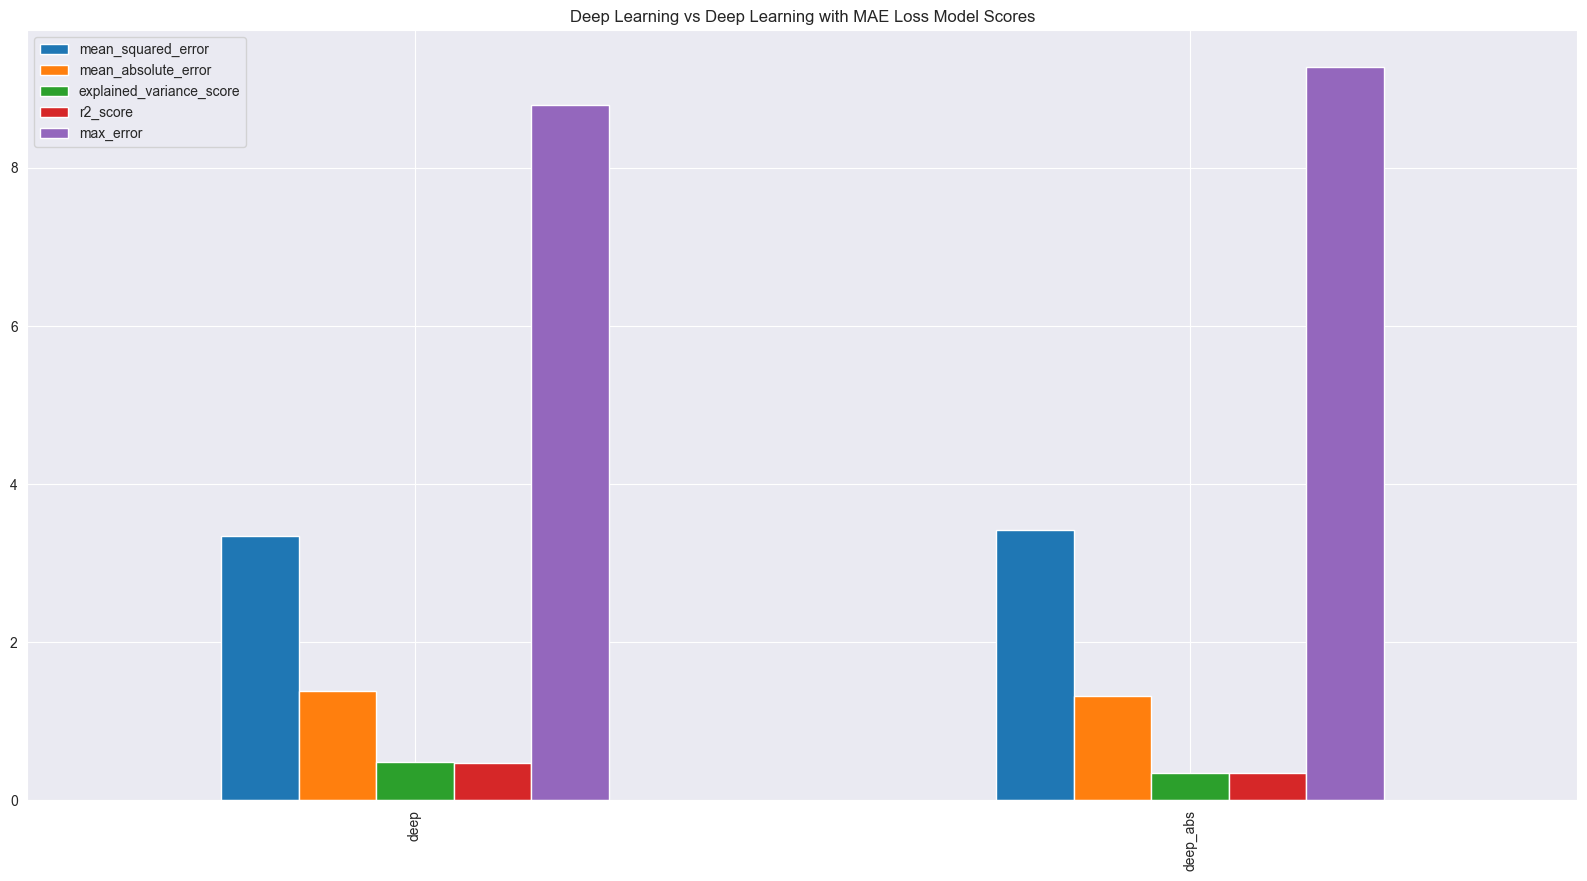

In [99]:
%%time
leaderboard_df.loc[['deep', 'deep_abs']].plot(kind='bar', title='Deep Learning vs Deep Learning with MAE Loss Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Deep Learning vs Deep Learning with MAE Loss


CPU times: total: 0 ns
Wall time: 37.6 ms


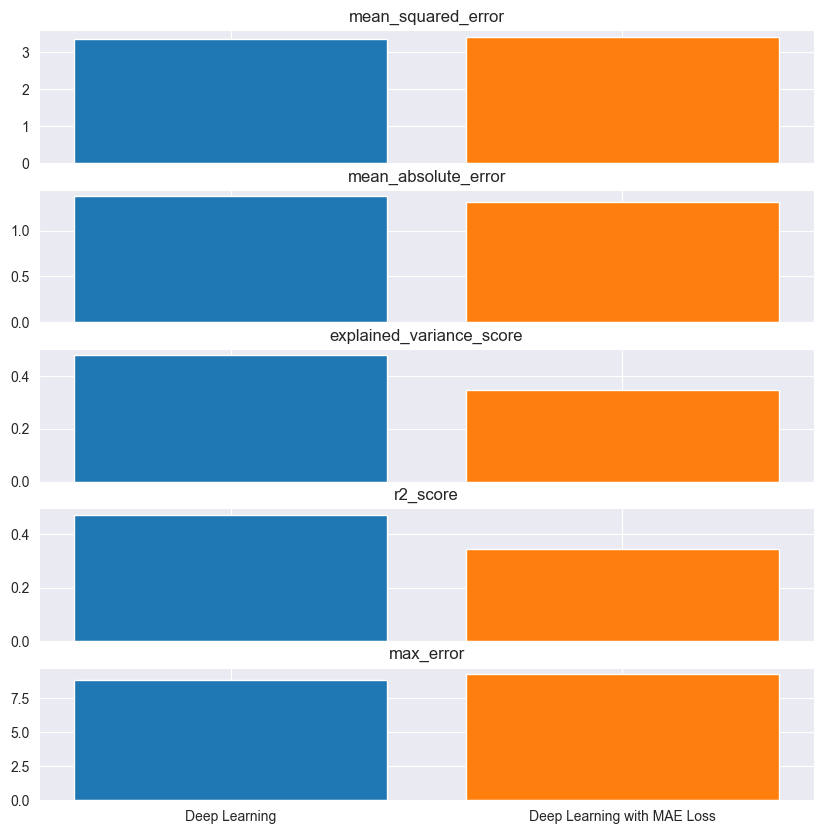

In [100]:
%%time
# Utility functions imported from mlutils.py
score_comparator(deep_scores_df, deep_abs_scores_df, train_label='Deep Learning', test_label='Deep Learning with MAE Loss')


### Observations: Deep Learning Model with MAE Loss

Well, that didn't help. It's better than the Feature-Rich model, but the Deep Learning model with Mean Squared Error loss is still the best.

Guess we won't have to get used to that new scale after all.


## Build the Deep Learning Model with Many Layers

We'll add more layers to the model to see if we can overfit the data.

### Architecture: Deep Learning Model with Many Layers

- **Input Layer**
    - We'll take all of the features, please.
- **Normalizer Layer**
- **Hidden Layers**
    - Four dense layers with 64 units and ReLU activation.
- **Output Layer**
    - Layer with one output.


In [101]:
%%time
# layer: input  - reusing the feature-rich input
# layer: normalizer - reusing the feature-rich normalizer

# layer(s): hidden 
num_hidden_layers = 4
layer_deeper_hidden_relu = \
    [keras.layers.Dense(units=64, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_deeper_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deeper_model = keras.Sequential([
    feature_rich_input,
    feature_rich_normalizer,
    *layer_deeper_hidden_relu,
    layer_deeper_output
])

deeper_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,270 (51.84 KB)

 Trainable params: 13,249 (51.75 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 23 ms


### Prepare the Deep Learning Model with Many Layers

Same as before, but with more layers.


In [102]:
%%time
deeper_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_deep_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('overfit', 'deep_deep'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 2 ms


### Train the Deep Learning Model with Many Layers

Let's train for 250 epochs to give it a chance to overfit.


In [103]:
%%time
deep_deep_history = deeper_model.fit(
    x=crabs.drop(columns=[PREDICTION_TARGET]),
    y=crabs[PREDICTION_TARGET],
    epochs=250,
    verbose=0,
    validation_split=0.2,
    callbacks=[deep_deep_checkpoint]
)


CPU times: total: 5.34 s
Wall time: 23.9 s


#### Plot Loss History

CPU times: total: 0 ns
Wall time: 7.02 ms


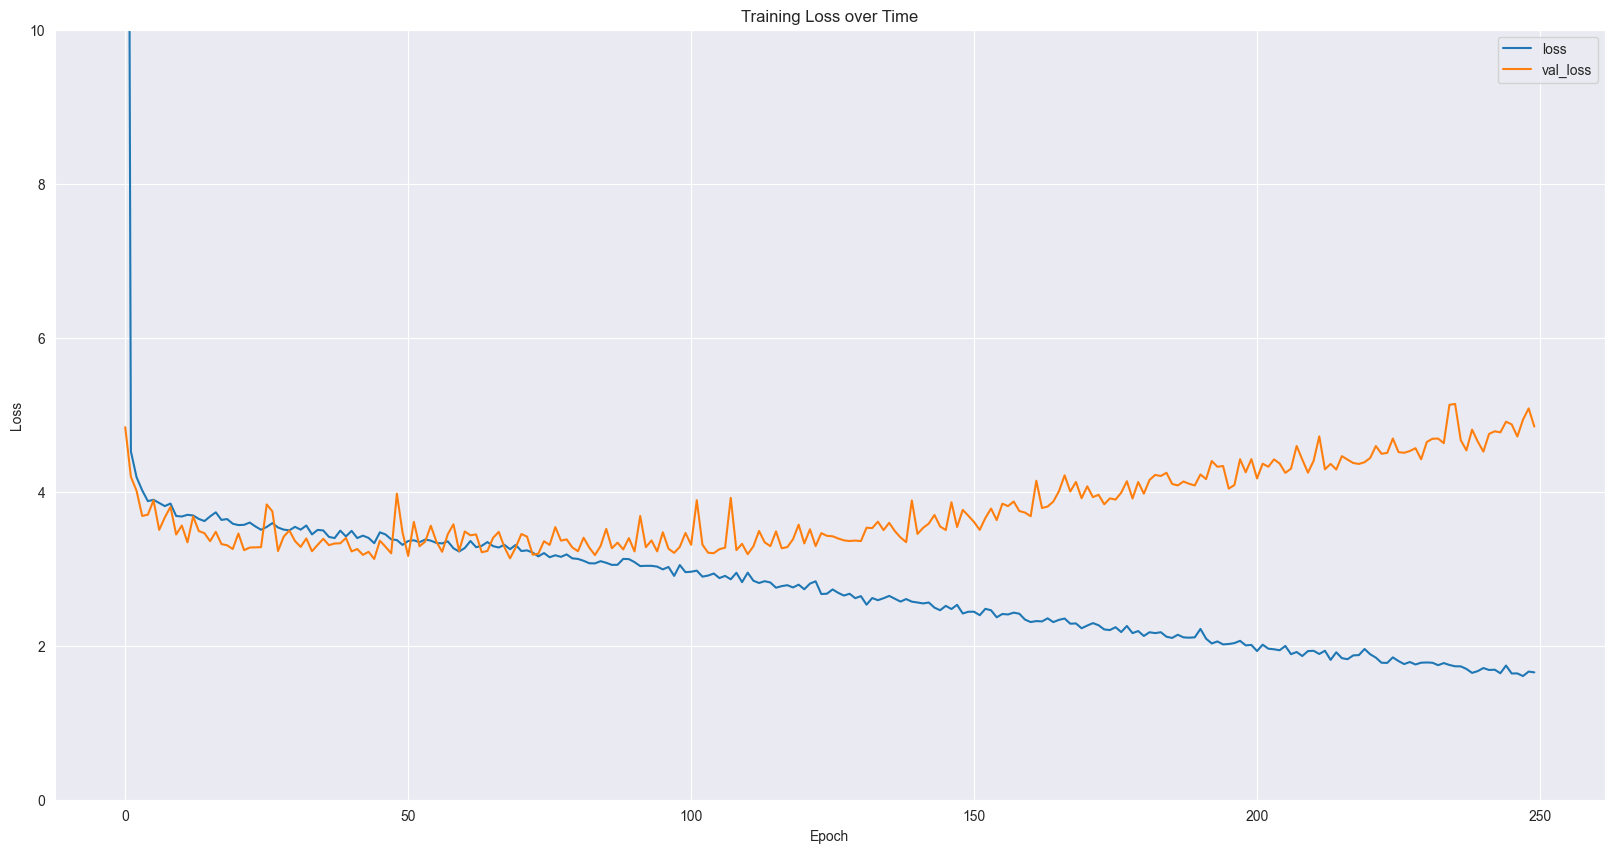

In [104]:
%%time
# Utility functions imported from mlutils.py
plot_training_loss(deep_deep_history)


### Predictions: Deep Learning Model with Many Layers

From the TensorFlow tutorial on [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#plot_the_training_and_validation_losses):


> Overfitting is apparent if you plot and compare the validation metrics to the training metrics.
>
>    - It's normal for there to be a small difference.
>    - If both metrics are moving in the same direction, everything is fine.
>    - If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
>    - If the validation metric is going in the wrong direction, the model is clearly overfitting.

Based on the plot, we're clearly overfitting!


In [105]:
%%time
deep_deep_preds = deeper_model.predict(crabs.drop(columns=[PREDICTION_TARGET])).flatten()

print(prediction_target)
print(deep_deep_preds)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
[9 6 6 ... 5 6 8]
[9.258409  8.0591545 7.3061943 ... 4.924354  6.838602  6.453564 ]
CPU times: total: 93.8 ms
Wall time: 176 ms


#### Scores: Deep Learning Model with Many Layers

Reminder of our metrics:

- **Mean Squared Error**
    - The best possible score is 0.0, lower values are better.
- **Mean Absolute Error**
    - The best possible score is 0.0, lower values are better. Less sensitive to outliers.
- **Explained Variance Score**
    - The best possible score is 1.0, lower values are worse.
- **R2 Score**
    - The best possible score is 1.0, lower values are worse.
- **Max Error**
    - The max error is the worst possible score. Domain-specific. 10 years is a lot for a crab.


In [106]:
%%time
# Utility functions imported from mlutils.py
deep_deep_scores_df = score_model(deep_deep_preds, prediction_target, index='deep_deep')
leaderboard_df = score_combine(leaderboard_df, deep_deep_scores_df)
leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 3 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
naive,109.296738,9.742229,-8.160315,-68.529752,25.271130
shell_weight,13.905619,3.343205,0.133495,-2.646485,7.286766
feature_rich,4.027237,1.512179,0.191359,0.186990,9.107718
deep,3.345500,1.377872,0.479164,0.473581,8.798338
deep_abs,3.421463,1.314849,0.346032,0.342647,9.276073
deep_deep,2.199302,1.039394,0.703587,0.703332,13.544180


### Comparison: Deep Learning vs Deep Learning with Many Layers

We know this model is overfitting, but let's see how it compares to the previous models.


CPU times: total: 15.6 ms
Wall time: 22.6 ms


<Axes: title={'center': 'Deep Learning vs Deep Learning with Many Layers Model Scores'}>

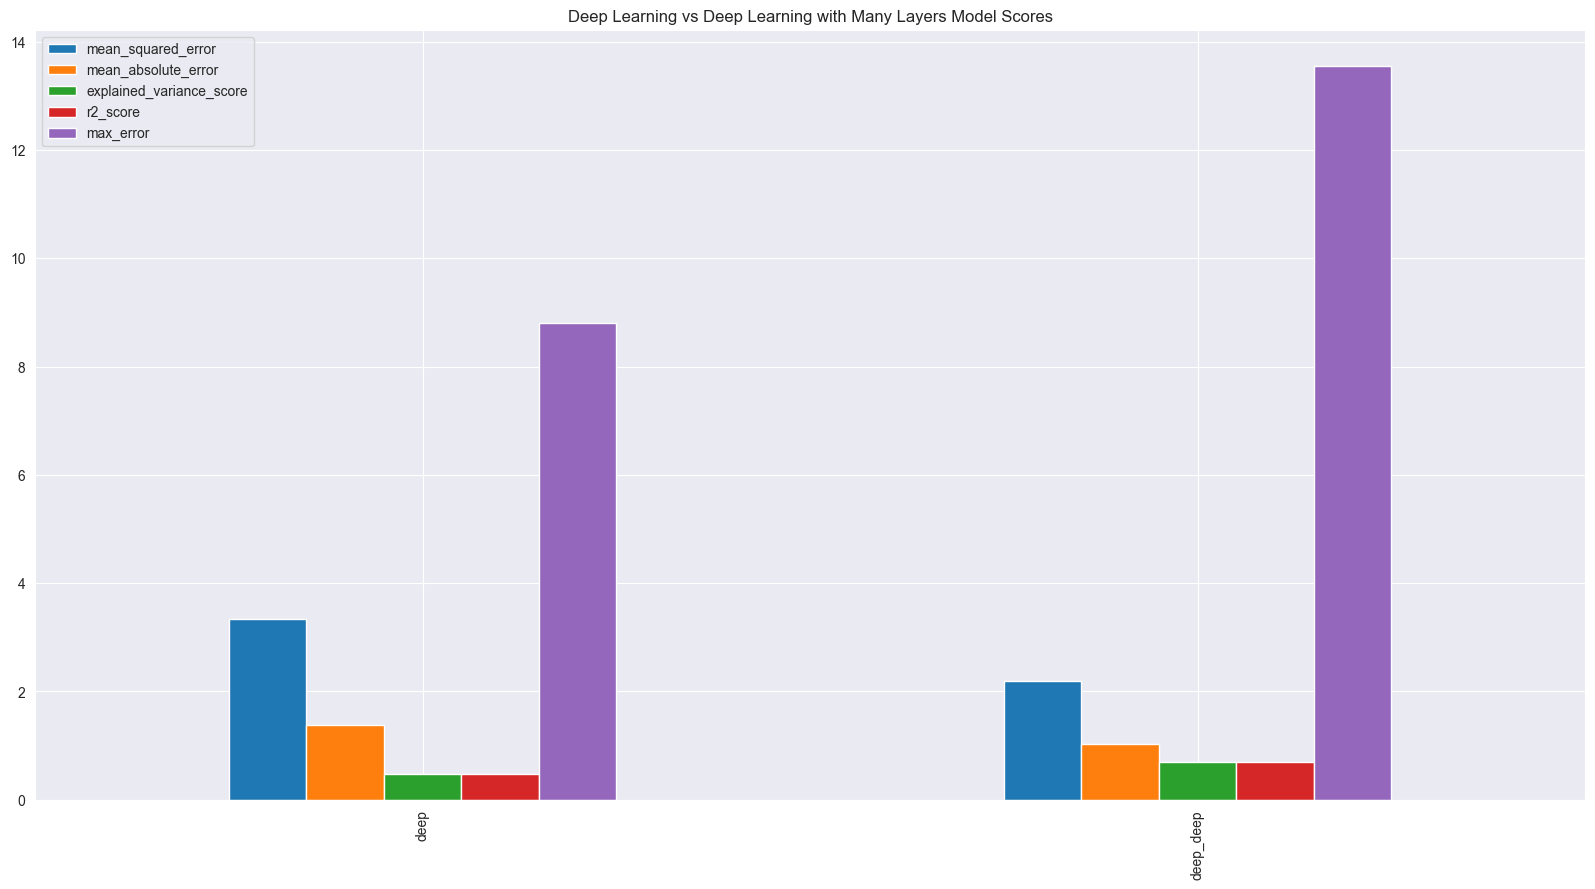

In [107]:
%%time
leaderboard_df.loc[['deep', 'deep_deep']].plot(kind='bar', title='Deep Learning vs Deep Learning with Many Layers Model Scores', figsize=(20, 10))


#### Score-by-Score Comparison: Deep Learning vs Deep Learning with Many Layers

Break down the bar charts into one for each metric.

CPU times: total: 31.2 ms
Wall time: 38.1 ms


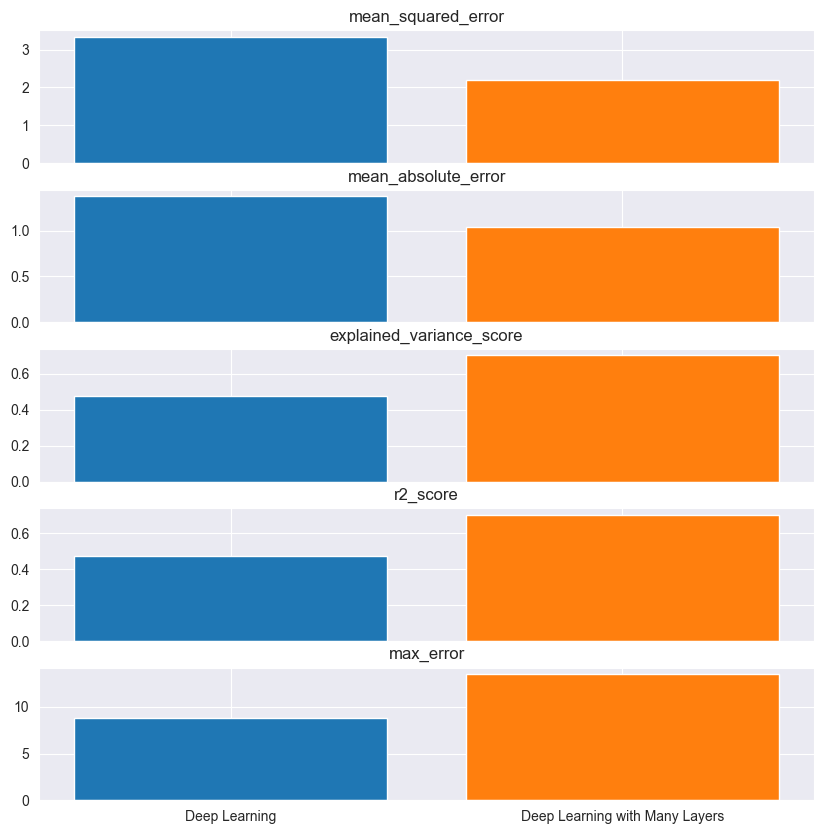

In [108]:
%%time
# Utility functions imported from mlutils.py
score_comparator(deep_scores_df, deep_deep_scores_df, train_label='Deep Learning', test_label='Deep Learning with Many Layers')


### Observations: Deep Learning Model with Many Layers

The scores are much better than the (shallow) Deep Learning model! We have successfully overfit the data.


## Don't Save this Data

We don't want our over-trained model to leak into the [next step](../1-models/models.ipynb).


## Onwards to Model Selection

See the [next section](../1-models/models.ipynb) for model selection.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/1-models/models.ipynb) for model selection.
